# import libraries

In [25]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from collections import Counter
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# load dataset

In [26]:
# Define the main directory for the dataset
directory = r'D:\datasets\lung\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset'

# Categories and their labels
categories = ["Bengin cases", "Malignant cases", "Normal cases"]
img_size = 256  # Image size for resizing


# prepare the data

In [27]:
# Initialize lists to store data
data = []
labels = []

print("Loading and preprocessing images...")
for category in categories:
    path = os.path.join(directory, category)
    class_num = categories.index(category)
    
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        try:
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (img_size, img_size))
            data.append(img_resized)
            labels.append(class_num)
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")


Loading and preprocessing images...


In [28]:
print("\nConverting to NumPy arrays and normalizing...")
data = np.array(data).reshape(-1, img_size, img_size, 1) / 255.0
labels = np.array(labels)

# Print original class distribution
print("\nOriginal class distribution:")
class_counts = Counter(labels)
for category, count in zip(categories, [class_counts[i] for i in range(len(categories))]):
    print(f"Class '{category}' has {count} images.")



Converting to NumPy arrays and normalizing...

Original class distribution:
Class 'Bengin cases' has 120 images.
Class 'Malignant cases' has 561 images.
Class 'Normal cases' has 416 images.


In [29]:
print("\nSplitting dataset before oversampling...")
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.125, stratify=y_train, random_state=42
)



Splitting dataset before oversampling...


In [30]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (767, 256, 256, 1)
X_test shape: (220, 256, 256, 1)
y_train shape: (767,)
y_test shape: (220,)


In [31]:
from imblearn.over_sampling import SMOTE
X_train_flattened = X_train.reshape(len(X_train), -1)  # Flatten for SMOTE

# Apply SMOTE
print("\nApplying SMOTE oversampling...")
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Auto balances classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape the resampled data back to original format
X_train_resampled = X_train_resampled.reshape(-1, img_size, img_size, 1)



Applying SMOTE oversampling...


In [32]:
y_train_resampled = to_categorical(y_train_resampled, num_classes=len(categories))
y_valid = to_categorical(y_valid, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

# Print new distribution after SMOTE
print("\nAfter oversampling:")
resampled_counts = Counter(np.argmax(y_train_resampled, axis=1))
for category, count in zip(categories, [resampled_counts[i] for i in range(len(categories))]):
    print(f"Class '{category}' has {count} images.")



After oversampling:
Class 'Bengin cases' has 392 images.
Class 'Malignant cases' has 392 images.
Class 'Normal cases' has 392 images.


In [33]:
print("\nDataset splits after correction:")
print(f"Training set shape: {X_train_resampled.shape}")
print(f"Validation set shape: {X_valid.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nData preprocessing complete!")



Dataset splits after correction:
Training set shape: (1176, 256, 256, 1)
Validation set shape: (110, 256, 256, 1)
Test set shape: (220, 256, 256, 1)

Data preprocessing complete!


# visualization

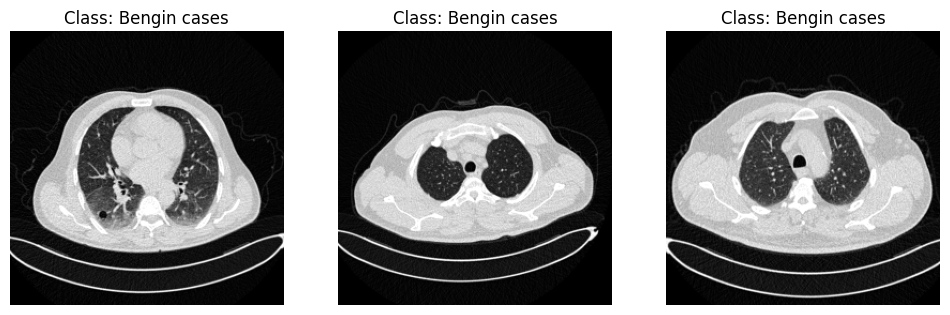

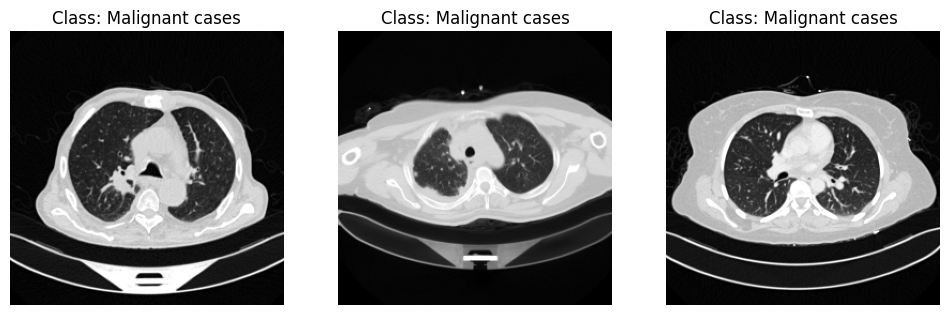

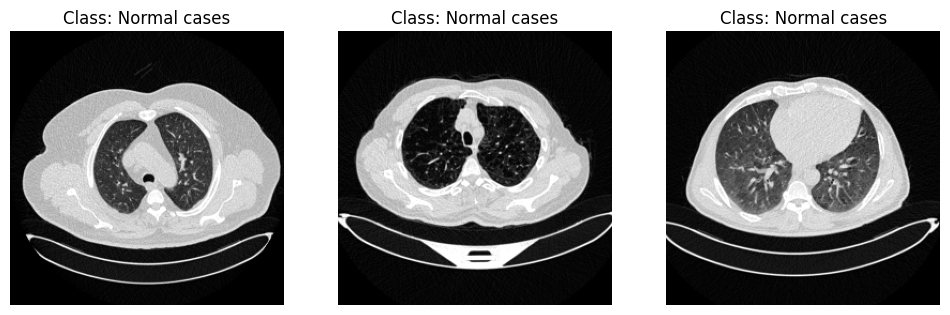

In [35]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Define the number of samples to display for each class
samples_to_display = 3

# Check if the labels are one-hot encoded or already numerical
if len(labels.shape) == 2 and labels.shape[1] > 1:
    # One-hot encoded labels: Get class indices using argmax
    label_indices = np.argmax(labels, axis=1)
else:
    # Numerical labels: Use them directly
    label_indices = labels

# Loop over each class
for i, category in enumerate(categories):
    # Get the indices of the images belonging to this class
    class_indices = np.where(label_indices == i)[0]  # Get class indices
    
    # Ensure that the number of samples does not exceed the number of images in the class
    num_samples = min(samples_to_display, len(class_indices))
    
    # Randomly select samples to display
    random_samples = random.sample(list(class_indices), num_samples)
    
    # Plot the images
    plt.figure(figsize=(12, 4))
    for j, sample_index in enumerate(random_samples):
        img = data[sample_index].reshape(img_size, img_size)  # Reshape back to the image dimensions
        plt.subplot(1, num_samples, j + 1)
        plt.imshow(img, cmap='gray')  # Display the image in grayscale
        plt.title(f"Class: {category}")
        plt.axis('off')
    
    # Show the plot for the current class
    plt.show()


# Densenet model

In [36]:
# Convert grayscale images to 3 channels for VGG16
x_train_rgb = np.repeat(X_train_resampled, 3, axis=-1)
x_valid_rgb = np.repeat(X_valid, 3, axis=-1)
x_test_rgb = np.repeat(X_test, 3, axis=-1)

In [37]:
# Load the DenseNet121 model as the base model
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model

# Create the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [38]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train_rgb, 
    y_train_resampled, 
    validation_data=(x_valid_rgb, y_valid), 
    epochs=25, 
    batch_size=32, 
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/25
37/37 [==============================] - 170s 4s/step - loss: 1.3951 - accuracy: 0.6667 - val_loss: 0.2850 - val_accuracy: 0.8909
Epoch 2/25
37/37 [==============================] - 119s 3s/step - loss: 0.2643 - accuracy: 0.8980 - val_loss: 0.2670 - val_accuracy: 0.8818
Epoch 3/25
37/37 [==============================] - 117s 3s/step - loss: 0.1634 - accuracy: 0.9405 - val_loss: 0.1506 - val_accuracy: 0.9545
Epoch 4/25
37/37 [==============================] - 112s 3s/step - loss: 0.1234 - accuracy: 0.9566 - val_loss: 0.1494 - val_accuracy: 0.9455
Epoch 5/25
37/37 [==============================] - 118s 3s/step - loss: 0.0966 - accuracy: 0.9728 - val_loss: 0.1089 - val_accuracy: 0.9545
Epoch 6/25
37/37 [==============================] - 116s 3s/step - loss: 0.0699 - accuracy: 0.9787 - val_loss: 0.0858 - val_accuracy: 0.9727
Epoch 7/25
37/37 [==============================] - 111s 3s/step - loss: 0.0479 - accuracy: 0.9881 - val_loss: 0.0970 - val_accuracy: 0.9636
Epoch 8/25
37

In [39]:
# Evaluate the model
y_pred = model.predict(x_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


7/7 [==============================] - 31s 3s/step


# Evaluation

In [40]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 99.55%


In [41]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.96      0.98        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       0.99      1.00      0.99        83

       accuracy                           1.00       220
      macro avg       1.00      0.99      0.99       220
   weighted avg       1.00      1.00      1.00       220

Confusion Matrix:
[[ 23   0   1]
 [  0 113   0]
 [  0   0  83]]


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [45]:

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 1.00
Recall: 0.99
F1 Score: 0.99


# save the model

In [43]:
model.save('final_model_lung.h5')
